In [7]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy as cart

from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco
import pandas as pd

from netCDF4 import Dataset

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import integrate_on_density_surfaces
from analysis_package import derive_potential_density_values_TEST

from importlib import reload

# reload modules during prototyping...
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)

"""
import sys
sys.path.append('/Users/Tatsu1/ECCOv4-py/ECCOv4-py/')
import ecco_v4_py_1 as ecco
"""
import os

In [8]:
grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)
GM_PSIX_var = "GM_PsiX"
GM_PSIY_var = "GM_PsiY"
tile_data_dir = "./nctiles_monthly/"

In [21]:
time_slice = np.arange(0,288)

In [22]:
GM_PSIX_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(tile_data_dir, 
                                                                GM_PSIX_var, 
                                                                time_slice)
GM_PSIY_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(tile_data_dir, 
                                                                GM_PSIY_var, 
                                                                time_slice)

Loaded GM_PsiX over time slice  

Loaded GM_PsiY over time slice  



In [23]:
GM_PSIX_ds_raw = GM_PSIX_ds_raw.drop("lon").drop("lat")
GM_PSIY_ds_raw = GM_PSIY_ds_raw.drop("lon").drop("lat")



In [24]:
# do some post-processing..
GM_PSIX_ds_raw = GM_PSIX_ds_raw.assign_coords(k=np.arange(0,50),j=np.arange(0,90),i=np.arange(0,90))
GM_PSIY_ds_raw = GM_PSIY_ds_raw.assign_coords(k=np.arange(0,50),j=np.arange(0,90),i=np.arange(0,90))

# trim datasets if final nan padding value is present.. otherwise this won't change anything
GM_PSIX_ds_raw = GM_PSIX_ds_raw.isel(i=slice(0,90),j=slice(0,90),k=slice(0,50))
GM_PSIY_ds_raw = GM_PSIY_ds_raw.isel(i=slice(0,90),j=slice(0,90),k=slice(0,50))
GM_PSIX_ds_raw.load()
GM_PSIY_ds_raw.load()

# add in tile coordinates
tiles = np.arange(0,13)
GM_PSIX_ds_raw["tile"] = tiles
GM_PSIY_ds_raw["tile"] = tiles
GM_PSIX_ds_raw = GM_PSIX_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic")
GM_PSIY_ds_raw = GM_PSIY_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic")



In [25]:
GM_PSIX_ds_raw["GM_PsiX"] = GM_PSIX_ds_raw.GM_PsiX.chunk((13,len(time_slice),50,90,90))
GM_PSIY_ds_raw["GM_PsiY"] = GM_PSIY_ds_raw.GM_PsiY.chunk((13,len(time_slice),50,90,90))



In [39]:
for tile in tiles:
    print("started tile " + str(tile))
    GM_PSIX_ds_raw_tile = GM_PSIX_ds_raw.isel(tile=tile)
    GM_PSIY_ds_raw_tile = GM_PSIY_ds_raw.isel(tile=tile)

    GM_PSIX_ds_plus_extra_k = xr.concat([GM_PSIX_ds_raw_tile,GM_PSIX_ds_raw_tile.isel(k=1)*np.nan],dim='k')
    GM_PSIY_ds_plus_extra_k = xr.concat([GM_PSIY_ds_raw_tile,GM_PSIY_ds_raw_tile.isel(k=1)*np.nan],dim='k')

    k_new_coords = np.arange(0,51)
    GM_PSIX_ds_plus_extra_k.coords.update({'k':k_new_coords})
    GM_PSIY_ds_plus_extra_k.coords.update({'k':k_new_coords})

    bolus_u = GM_PSIX_ds_plus_extra_k.copy(deep=True)
    bolus_v = GM_PSIY_ds_plus_extra_k.copy(deep=True)
    bolus_u = bolus_u.rename({'GM_PsiX':'bolus_uvel'})
    bolus_v = bolus_v.rename({'GM_PsiY':'bolus_vvel'})
    bolus_u.load()
    bolus_v.load()

    for k in range(0,50):
        bolus_u.bolus_uvel[:,k,:,:] = (GM_PSIX_ds_plus_extra_k.GM_PsiX[:,k+1,:,:] - GM_PSIX_ds_plus_extra_k.GM_PsiX[:,k,:,:])/grid.drF[k]
        bolus_v.bolus_vvel[:,k,:,:] = (GM_PSIY_ds_plus_extra_k.GM_PsiY[:,k+1,:,:] - GM_PSIY_ds_plus_extra_k.GM_PsiY[:,k,:,:])/grid.drF[k]

    bolus_u = bolus_u.isel(k=slice(0,50)).copy(deep=True).rename({'i':'i_g'})
    bolus_v = bolus_v.isel(k=slice(0,50)).copy(deep=True).rename({'j':'j_g'})
    
    if tile < 9:
        pass
        bolus_u.to_netcdf(tile_data_dir+"BOLUS_UVEL/BOLUS_UVEL.000"+str(tile+1)+".nc")
        bolus_v.to_netcdf(tile_data_dir+"BOLUS_VVEL/BOLUS_VVEL.000"+str(tile+1)+".nc")
    else:
        pass
        bolus_u.to_netcdf(tile_data_dir+"BOLUS_UVEL/BOLUS_UVEL.00"+str(tile+1)+".nc")
        bolus_v.to_netcdf(tile_data_dir+"BOLUS_VVEL/BOLUS_VVEL.00"+str(tile+1)+".nc")

    print("saved tile " + str(tile))



started tile 0
saved tile 0
started tile 1
saved tile 1
started tile 2
saved tile 2
started tile 3
saved tile 3
started tile 4
saved tile 4
started tile 5
saved tile 5
started tile 6
saved tile 6
started tile 7
saved tile 7
started tile 8
saved tile 8
started tile 9
saved tile 9
started tile 10
saved tile 10
started tile 11
saved tile 11
started tile 12
saved tile 12


In [40]:
print(GM_PSIX_ds_raw["GM_PsiX"].isel(time=0,k=0))

<xarray.DataArray 'GM_PsiX' (tile: 13, j: 90, i: 90)>
dask.array<shape=(13, 90, 90), dtype=float64, chunksize=(13, 90, 90)>
Coordinates:
    time     float64 1.0
    k        int64 0
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    dep      float64 10.0
    tim      datetime64[ns] 1992-01-16
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  GM Bolus transport stream-function : U component
    units:      m^2/s


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

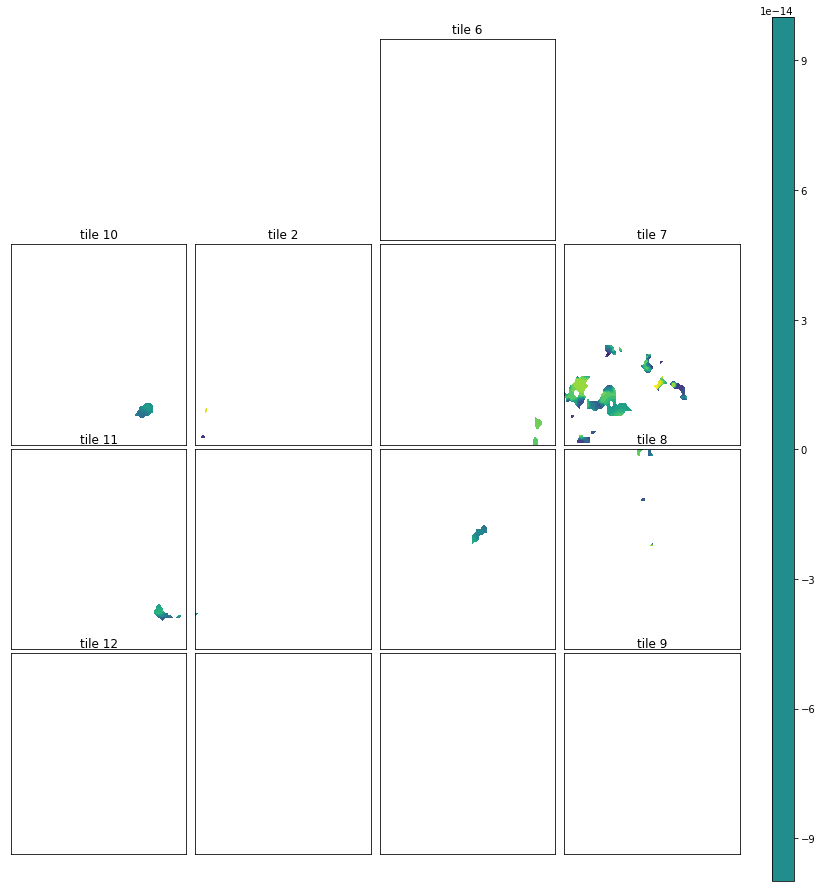

In [45]:
plotting_functions.world_plot(GM_PSIX_ds_raw["GM_PsiX"].isel(time=0,k=49))

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

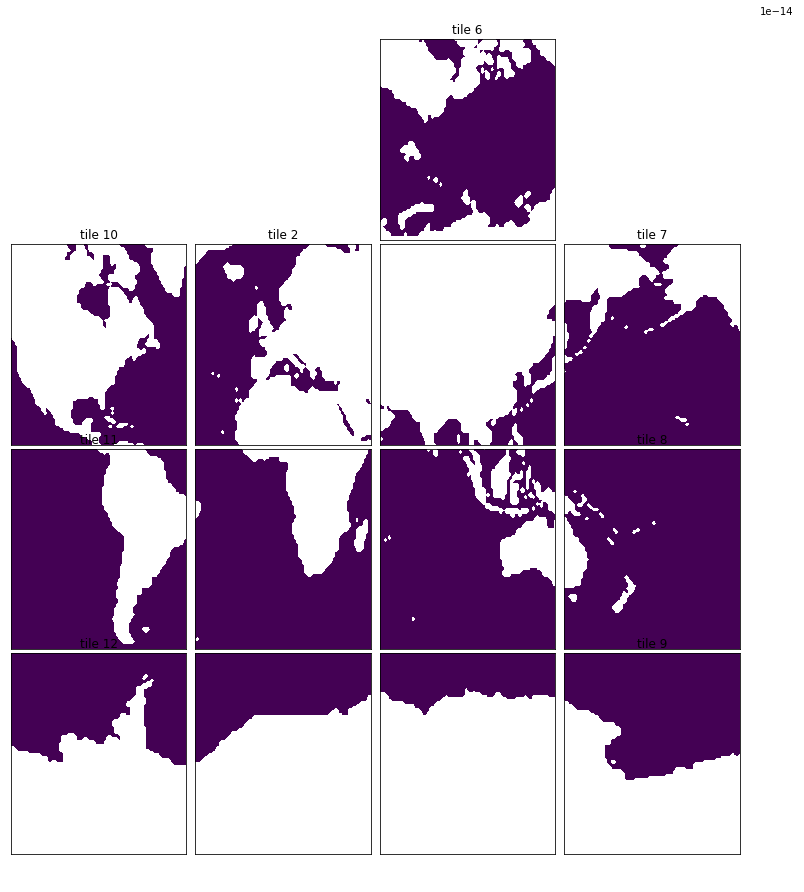

In [42]:
plotting_functions.world_plot(GM_PSIY_ds_raw["GM_PsiY"].isel(time=0,k=0))